In [1]:
import os
import genomepy
import pandas as pd
from torch.nn import functional as F
import torch
import numpy as np
import pyranges
import matplotlib.pyplot as plt

In [2]:
rnaseq = pd.read_table("data/rnaseq/rnaseq.rsem_genes_fpkm.txt")

In [3]:
rnaseq_trimmed = rnaseq[
    ["gene_name"] + 
    [
        col 
        for col in rnaseq.columns 
        if any([(tissue in col) for tissue in ["0001_", "0002_", "0003_", "0004_"]]) 
    ]
]

In [4]:
rnaseq_melted = rnaseq_trimmed.melt(["gene_name"], var_name="tissue")
rnaseq_melted["tissue_id"] = rnaseq_melted["tissue"].apply(lambda x: x[:4])
rnaseq_melted = rnaseq_melted.groupby(["tissue_id", "gene_name"]).agg({"tissue": "first", "value": "mean"}).reset_index()
rnaseq_unmelted = rnaseq_melted.pivot(index="tissue_id", columns="gene_name", values="value")
import json
rnaseq_genes = json.load(open("data/intermediates/rnaseq_variables.json"))
rnaseq_unmelted = rnaseq_unmelted[rnaseq_genes]
rnaseq_unmelted = rnaseq_unmelted / (rnaseq_unmelted + 1)

In [5]:
def prepare_for_merge(data_file, top_N_reads, tissue):
    df = pd.read_table(data_file).sort_values("N_reads", ascending=False).head(top_N_reads)
    df["tissue"] = tissue
    return df

standard_size = 2048
def expand_enrich_pchic(df):
    df[["bait_frag_chr", "bait_frag_start", "bait_frag_end"]] = df["bait_frag"].str.split(",", expand=True)
    df[["other_frag_chr", "other_frag_start", "other_frag_end"]] = df["other_frag"].str.split(",", expand=True)
    df["bait_size"] = np.abs(df["bait_frag_start"].apply(int) - df["bait_frag_end"].apply(int))
    df["other_size"] = np.abs(df["other_frag_start"].apply(int) - df["other_frag_end"].apply(int))
    df["bait_frag_midpoint"] = df.apply(lambda x: int((int(x["bait_frag_start"]) + int(x["bait_frag_end"])) / 2), axis=1)
    df["bait_frag_standard_size_start"] = df["bait_frag_midpoint"] - standard_size
    df["bait_frag_standard_size_end"]   = df["bait_frag_midpoint"] + standard_size - 1
    df["other_frag_midpoint"] = df.apply(lambda x: int((int(x["other_frag_start"]) + int(x["other_frag_end"])) / 2), axis=1)
    df["other_frag_standard_size_start"] = df["other_frag_midpoint"] - standard_size
    df["other_frag_standard_size_end"]   = df["other_frag_midpoint"] + standard_size - 1
    negative_starting = df.loc[df["other_frag_standard_size_start"] <= 0, "other_frag_standard_size_start"]
    negative_ending = df.loc[df["other_frag_standard_size_start"] <= 0, "other_frag_standard_size_end"]
    df.loc[negative_starting.index, "other_frag_standard_size_end"] = (negative_ending - negative_starting + 1).apply(int)
    df.loc[negative_starting.index, "other_frag_standard_size_start"] = 1
    return df

df_multi_tissue = pd.concat((
    prepare_for_merge("data/pchic/0057_Thymus_merged_loop.txt", 10_000, "0001"),
    prepare_for_merge("data/pchic/0002_Embryo - Trophoblast_merged_loop.txt", 10_000, "0002"),
    prepare_for_merge("data/pchic/0003_Spleen_merged_loop.txt", 10_000, "0003"),
    prepare_for_merge("data/pchic/0004_Small Intestine - Terminal Ileum_merged_loop.txt", 10_000, "0004"),
))
df_multi_tissue = expand_enrich_pchic(df_multi_tissue)

In [6]:
EXTRA_SAMPLES = 0
import genomepy
hg = genomepy.Genome("hg19")

def generate_random_negatives(data, bait):
    data_focused = data[data["bait_frag"] == bait]
    bait_midpoint = data_focused["bait_frag_midpoint"].values[0]
    chr = bait.split(",")[0]

    others = data_focused["other_frag_midpoint"]
    
    other_std = pd.concat((others, pd.Series(bait_midpoint))).std() # avoid situations of 1 other
    other_n = len(others)

    candidate_midpoint = np.random.normal(bait_midpoint, other_std, size=other_n*3 + EXTRA_SAMPLES)
    candidate_midpoint = candidate_midpoint.astype(int)

    generated = pyranges.PyRanges(pd.DataFrame({
        "Chromosome": chr, 
        "Start": candidate_midpoint - standard_size, 
        "End": candidate_midpoint + standard_size
    }))

    actual = pyranges.PyRanges(
        data_focused[["other_frag_chr", "other_frag_standard_size_start", "other_frag_standard_size_end"]]
        .rename(columns = {
            "other_frag_chr": "Chromosome", 
            "other_frag_standard_size_start": "Start", 
            "other_frag_standard_size_end": "End"
        })
    )

    filtered_overlaps = generated.subtract(actual)
    filtered_overruns = filtered_overlaps.df[(filtered_overlaps.df["End"] < hg.sizes[chr]) & (filtered_overlaps.df["Start"] > 0)]
    reduced = filtered_overruns[:other_n + EXTRA_SAMPLES]
    reduced = reduced["Chromosome"].astype(str) + "," + reduced["Start"].astype(str) + "," + reduced["End"].astype(str)

    return pd.DataFrame({
        "bait_frag" : bait,
        "other_frag": reduced,
        "tissue": data_focused["tissue"].values[0]
    })

def generate_random_negatives_df(data):
    from tqdm.notebook import tqdm
    import warnings
    
    all_generated = []
    for bait in tqdm(data["bait_frag"].unique()):
        with warnings.catch_warnings(action="ignore"):
            all_generated.append(
                generate_random_negatives(data, bait)
            )
    return pd.concat(all_generated)

In [80]:
df_negatives = generate_random_negatives_df(df_multi_tissue)
df_negatives = expand_enrich_pchic(df_negatives)
df_negatives

  0%|          | 0/10440 [00:00<?, ?it/s]

,bait_frag,other_frag,tissue,bait_frag_chr,bait_frag_start,bait_frag_end,other_frag_chr,other_frag_start,other_frag_end,bait_size,other_size,bait_frag_midpoint,bait_frag_standard_size_start,bait_frag_standard_size_end,other_frag_midpoint,other_frag_standard_size_start,other_frag_standard_size_end
0,"chr1,149812977,149815602","chr1,149790262,149794358",0001,chr1,149812977,149815602,chr1,149790262,149794358,2625,4096,149814289,149812241,149816336,149792310,149790262,149794357
1,"chr1,149812977,149815602","chr1,149823514,149824929",0001,chr1,149812977,149815602,chr1,149823514,149824929,2625,1415,149814289,149812241,149816336,149824221,149822173,149826268
2,"chr1,149812977,149815602","chr1,149804987,149809083",0001,chr1,149812977,149815602,chr1,149804987,149809083,2625,4096,149814289,149812241,149816336,149807035,149804987,149809082
3,"chr1,149812977,149815602","chr1,149808982,149813078",0001,chr1,149812977,149815602,chr1,149808982,149813078,2625,4096,149814289,149812241,149816336,149811030,149808982,149813077
4,"chr1,149812977,149815602","chr1,149824481,149828577",0001,chr1,149812977,149815602,chr1,149824481,149828577,2625,4096,149814289,149812241,149816336,149826529,149824481,149828576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"chr13,77563430,77571739","chr13,77828461,77832557",0004,chr13,77563430,77571739,chr13,77828461,77832557,8309,4096,77567584,77565536,77569631,77830509,77828461,77832556
0,"chr4,88529147,88531504","chr4,88425780,88429876",0004,chr4,88529147,88531504,chr4,88425780,88429876,2357,4096,88530325,88528277,88532372,88427828,88425780,88429875
0,"chr16,62065676,62073458","chr16,62072610,62076706",0004,chr16,62065676,62073458,chr16,62072610,62076706,7782,4096,62069567,62067519,62071614,62074658,62072610,62076705
0,"chr19,15849499,15851326","chr19,15389581,15393677",0004,chr19,15849499,15851326,chr19,15389581,15393677,1827,4096,15850412,15848364,15852459,15391629,15389581,15393676


In [81]:
df_multi_tissue["factual"] = 1
df_negatives["factual"] = 0

In [82]:
combined = pd.concat((
    df_multi_tissue[[
        "bait_frag_chr",
        "bait_frag_standard_size_start", 
        "bait_frag_standard_size_end", 
        "other_frag_chr",
        "other_frag_standard_size_start", 
        "other_frag_standard_size_end", 
        "tissue",
        "factual"
    ]],
    df_negatives[[
        "bait_frag_chr",
        "bait_frag_standard_size_start", 
        "bait_frag_standard_size_end", 
        "other_frag_chr",
        "other_frag_standard_size_start", 
        "other_frag_standard_size_end", 
        "tissue",
        "factual"
    ]],
))

In [88]:
combined.reset_index(drop=True)

,bait_frag_chr,bait_frag_standard_size_start,bait_frag_standard_size_end,other_frag_chr,other_frag_standard_size_start,other_frag_standard_size_end,tissue,factual
0,chr1,149812241,149816336,chr1,149814713,149818808,0001,1
1,chr2,27599844,27603939,chr2,27592913,27597008,0001,1
2,chr20,5089723,5093818,chr20,5094753,5098848,0001,1
3,chr5,176739196,176743291,chr5,176745700,176749795,0001,1
4,chr12,133332343,133336438,chr12,133342264,133346359,0001,1
...,...,...,...,...,...,...,...,...
79995,chr13,77565536,77569631,chr13,77828461,77832556,0004,0
79996,chr4,88528277,88532372,chr4,88425780,88429875,0004,0
79997,chr16,62067519,62071614,chr16,62072610,62076705,0004,0
79998,chr19,15848364,15852459,chr19,15389581,15393676,0004,0


In [85]:
combined.to_csv("data/intermediates/multi-tissue/mt1-4.csv")

In [7]:
combined = pd.read_csv("data/intermediates/multi-tissue/mt1-4.csv")
combined["tissue"] = combined["tissue"].apply(lambda x: f"000{x}")

In [8]:
data_train = combined.sample(frac=0.75)
data_test = combined.drop(data_train.index)
data_train = data_train.reset_index()
data_test = data_test.reset_index()

In [9]:
def make_conv_block():
    return torch.nn.Sequential(
        torch.nn.Conv1d(96, 96, 5, padding=2),
        torch.nn.BatchNorm1d(96),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool1d(2)
    )

In [10]:
def make_conv_stack():
    return torch.nn.Sequential(
        torch.nn.Sequential(
            torch.nn.Conv1d(4, 96, 11, padding=5),
            torch.nn.BatchNorm1d(96),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool1d(2)
        ),
        *[make_conv_block() for _ in range(4)]
    )

In [11]:
class DilatedResidualConvolution(torch.nn.Module):
    def __init__(self, dilation, dropout_rate=0.25):
        super(DilatedResidualConvolution, self).__init__()
        self.dilate_block = torch.nn.Sequential(
            torch.nn.Conv1d(96, 48, 3, padding=dilation, dilation=dilation),
            torch.nn.BatchNorm1d(48),
            torch.nn.ReLU(inplace=True),
        )
        self.return_block = torch.nn.Sequential(
            torch.nn.Conv1d(48, 96, 3, padding=dilation, dilation=dilation),
            torch.nn.BatchNorm1d(96),
            torch.nn.Dropout(dropout_rate)
        )
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x 
        x = self.dilate_block(x)
        x = self.return_block(x)
        x += identity
        x = self.relu(x)
        return x


In [12]:
def make_dilation_stack():
    return torch.nn.Sequential(
        *[DilatedResidualConvolution(2**i) for i in range(1, 5)]
    )

In [13]:
class PoCNetAkitalike(torch.nn.Module):
    def __init__(self):
        super(PoCNetAkitalike, self).__init__()
        self.bait_block = torch.nn.Sequential(
            make_conv_stack(),
            # make_dilation_stack()
        )
        self.other_block = torch.nn.Sequential(
            make_conv_stack(),
            # make_dilation_stack()
        )

        self.head = torch.nn.Sequential(
            torch.nn.Linear(2 * 96 * 128 + 1000, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 1)
        )

    def forward(self, x_1, x_2, rnaseq):
        x_1 = self.bait_block(x_1)
        x_1 = torch.flatten(x_1, start_dim=1)

        x_2 = self.other_block(x_2)
        x_2 = torch.flatten(x_2, start_dim=1)
        
        x = torch.concat((x_1, x_2, rnaseq), dim=1)
        x = self.head(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        # x = self.fc3(x)
        # x = F.sigmoid(x)
        return x

In [14]:
model = PoCNetAkitalike().cuda()

In [15]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [16]:
def fasta_to_ohe_mapping(ascii_dna):
        if ascii_dna == 65:  # A
            return 1
        if ascii_dna == 67:  # C
            return 2
        if ascii_dna == 71:  # G
            return 3
        if ascii_dna == 84:  # T
            return 4
        if ascii_dna == 97:  # a
            return 1
        if ascii_dna == 99:  # c
            return 2
        if ascii_dna == 103: # g
            return 3
        if ascii_dna == 116: # t
            return 4
        return 0 # Nn, anything else

def from_loc_to_ohe(chr, start, end):
    sequence = hg.get_seq(chr, start, end)
    buffer = torch.frombuffer(sequence.seq.encode(), dtype=torch.uint8)
    buffer = buffer.apply_(fasta_to_ohe_mapping)
    atcg_mask = buffer != 0 # 1 if actg, 0 otherwise
    buffer -= atcg_mask * 1 # offset indexing for atcg so it starts at 0 instead of 1
                            # this is needed to have the "others" be a 0000 row in OHE
    return (
        F.one_hot(buffer.long(), num_classes=4).T * atcg_mask # OHE and mask others
    )

In [17]:
def chunk_df(df, n):
    return [df[i:i+n] for i in range(0,df.shape[0],n)]

def from_loc_to_ohe_batch(df, prefix: ["bait", "other"]):
    return torch.stack([
        from_loc_to_ohe(row[f"{prefix}_frag_chr"], row[f"{prefix}_frag_standard_size_start"], row[f"{prefix}_frag_standard_size_end"])
        for _, row in df.iterrows()
    ])

In [18]:
torch.cuda.empty_cache()

In [19]:
model.train(True)
from tqdm.notebook import tqdm
best_accuracy = 0

for epoch in range(1, 200):
    model.train(True)
    for batch in (chunk_df(data_train.sample(frac=1.), 100)):
        optimizer.zero_grad()
        
        bait_ohe = from_loc_to_ohe_batch(batch, "bait")
        other_ohe = from_loc_to_ohe_batch(batch, "other")
        rnaseq = torch.from_numpy(np.array(batch["tissue"].apply(lambda x: rnaseq_unmelted.loc[x])))
        yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda(), rnaseq.float().cuda())
        yhat = yhat.cpu().flatten()
        y = torch.from_numpy(batch["factual"].values).float()
        loss = loss_function(yhat, y)
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss: .5f} Accuracy {sum((F.sigmoid(yhat) >= .5) == y)/len(y):.5f} Ones% {sum((F.sigmoid(yhat) >= .5) == 1)/len(y):.5f}", end="\r")
    print()
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_so_far = 0
        for batch in (chunk_df(data_test.sample(frac=1.), 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            rnaseq = torch.from_numpy(np.array(batch["tissue"].apply(lambda x: rnaseq_unmelted.loc[x])))
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda(), rnaseq.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            total_correct += sum((F.sigmoid(yhat) >= .5) == y)
            total_so_far += len(y)
        print(f"{total_correct/total_so_far: .5f}", end="\r")
        if total_correct/total_so_far > best_accuracy:
            torch.save(model, "data/models/amt1_best")
    print()

/tmp/ipykernel_12534/361536034.py:22: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1563.)
  buffer = torch.frombuffer(sequence.seq.encode(), dtype=torch.uint8)
/home/kacper/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss:  0.58937 Accuracy 0.71000 Ones% 0.42000
 0.66150
Loss:  0.59943 Accuracy 0.67000 Ones% 0.46000
 0.65250
Loss:  0.56628 Accuracy 0.69000 Ones% 0.49000
 0.68370
Loss:  0.50903 Accuracy 0.72000 Ones% 0.50000
 0.67655
Loss:  0.57370 Accuracy 0.68000 Ones% 0.58000
 0.66550
Loss:  0.47711 Accuracy 0.72000 Ones% 0.50000
 0.67035
Loss:  0.46516 Accuracy 0.74000 Ones% 0.39000
 0.66910
Loss:  0.44404 Accuracy 0.80000 Ones% 0.40000
 0.65875
Loss:  0.34990 Accuracy 0.87000 Ones% 0.59000
 0.60835
Loss:  0.32584 Accuracy 0.85000 Ones% 0.39000
 0.64795


KeyboardInterrupt: 

In [21]:
model = torch.load("data/models/amt1_best")

In [54]:
model.eval()
yhat_list = []
with torch.no_grad():
        for batch in tqdm(chunk_df(data_train, 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            rnaseq = torch.from_numpy(np.array(batch["tissue"].apply(lambda x: rnaseq_unmelted.loc[x])))
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda(), rnaseq.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            yhat_list.append(F.sigmoid(yhat))

  0%|          | 0/600 [00:00<?, ?it/s]

/home/kacper/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [56]:
np.mean(((torch.cat(yhat_list) >= .5) +0).numpy() == data_train["factual"].values) #accuracy

0.9258833333333333

0.9798947065690883


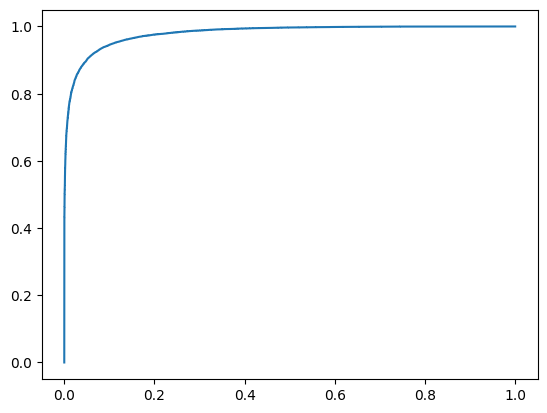

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
print(roc_auc_score(data_train["factual"].values, torch.cat(yhat_list)))
fpr, tpr, thresholds = roc_curve(data_train["factual"].values, torch.cat(yhat_list))
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)

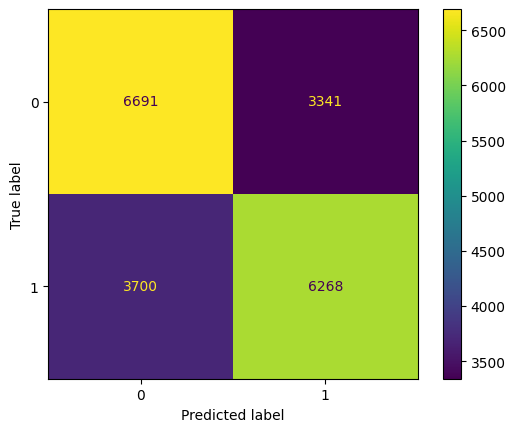

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(    data_test["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy())

In [39]:
model.eval()
yhat_list = []
with torch.no_grad():
        for batch in tqdm(chunk_df(data_test, 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            rnaseq = torch.from_numpy(np.array(batch["tissue"].apply(lambda x: rnaseq_unmelted.loc[x])))
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda(), rnaseq.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            yhat_list.append(F.sigmoid(yhat))

  0%|          | 0/200 [00:00<?, ?it/s]

In [40]:
np.mean(((torch.cat(yhat_list) >= .5) +0).numpy() == data_test["factual"].values) #accuracy

0.64795

0.7071671663917839


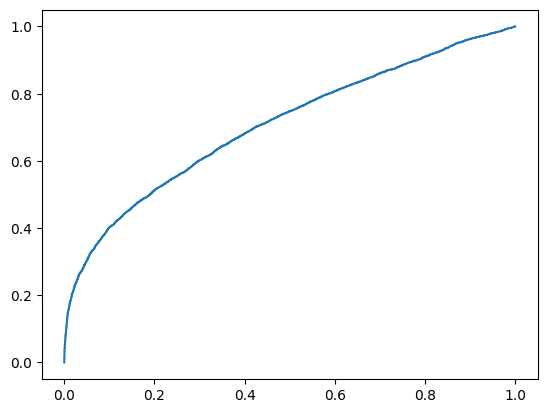

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
print(roc_auc_score(data_test["factual"].values, torch.cat(yhat_list)))
fpr, tpr, thresholds = roc_curve(data_test["factual"].values, torch.cat(yhat_list))
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)

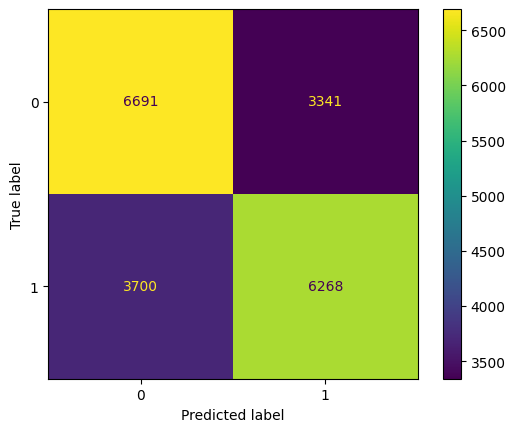

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(    data_test["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy())

In [44]:
left_out = prepare_for_merge("data/pchic/0067_Blood - Total CD4+ Cells_merged_loop.txt", 10_000, "0067") 
left_out = expand_enrich_pchic(left_out)
left_out["factual"] = 1

In [45]:
rnaseq_trimmed = pd.read_table("data/rnaseq/rnaseq.rsem_genes_fpkm.txt")[
    ["gene_name"] + 
    [
        col 
        for col in pd.read_table("data/rnaseq/rnaseq.rsem_genes_fpkm.txt").columns 
        if any([(tissue in col) for tissue in ["0067_"]]) 
    ]
]
rnaseq_melted = rnaseq_trimmed.melt(["gene_name"], var_name="tissue")
rnaseq_melted["tissue_id"] = rnaseq_melted["tissue"].apply(lambda x: x[:4])
rnaseq_melted = rnaseq_melted.groupby(["tissue_id", "gene_name"]).agg({"tissue": "first", "value": "mean"}).reset_index()
rnaseq_unmelted_t = rnaseq_melted.pivot(index="tissue_id", columns="gene_name", values="value")

In [46]:
rnaseq_unmelted_t = rnaseq_unmelted_t[rnaseq_unmelted.columns]
rnaseq_unmelted_t =  rnaseq_unmelted_t/(rnaseq_unmelted_t+1)

In [47]:
left_out_negatives = generate_random_negatives_df(left_out)

  0%|          | 0/3276 [00:00<?, ?it/s]

In [48]:
left_out_negatives = expand_enrich_pchic(left_out_negatives)
left_out_negatives["factual"] = 0

In [50]:
model.eval()
yhat_list = []
with torch.no_grad():
        for batch in tqdm(chunk_df(pd.concat((left_out, left_out_negatives)), 100)):        
            bait_ohe = from_loc_to_ohe_batch(batch, "bait")
            other_ohe = from_loc_to_ohe_batch(batch, "other")
            rnaseq = torch.from_numpy(np.array(batch["tissue"].apply(lambda x: rnaseq_unmelted_t.loc[x])))
            yhat = model.forward(bait_ohe.float().cuda(), other_ohe.float().cuda(), rnaseq.float().cuda())
            yhat = yhat.cpu().flatten()
            y = torch.from_numpy(batch["factual"].values).float()
            yhat_list.append(F.sigmoid(yhat))

  0%|          | 0/200 [00:00<?, ?it/s]

/home/kacper/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [51]:
np.mean(((torch.cat(yhat_list) >= .5) +0).numpy() == data_test["factual"].values) #accuracy

0.5608

0.6484242948647794


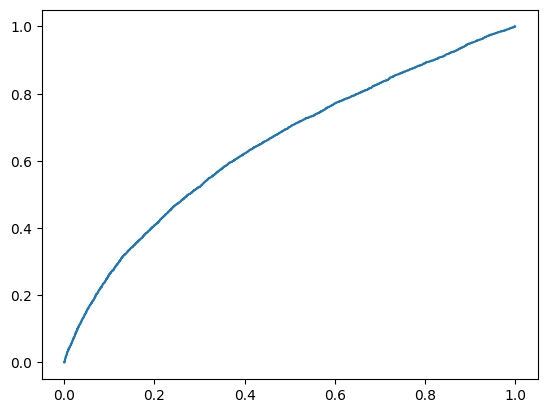

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
print(roc_auc_score(data_test["factual"].values, torch.cat(yhat_list)))
fpr, tpr, thresholds = roc_curve(data_test["factual"].values, torch.cat(yhat_list))
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)

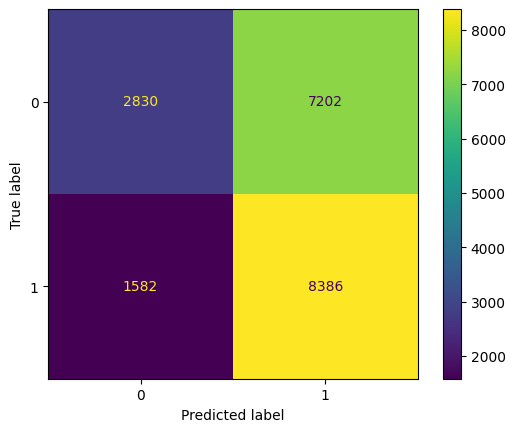

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(    data_test["factual"].values,
    ((torch.cat(yhat_list) >= .5) +0).numpy())